In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
# from plotly.subplots import make_subplots

In [2]:
SEED = 45678
np.random.seed(SEED)

In [3]:
df = pd.read_excel('../data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
# Label output
# 'ICU' should be considered, as the first version of this dataset, the target variable.

# Window Concept
# -- patient encounter
# -- aggregated by windows in chronological order
# e.g. '2-4': From 2 to 4 hours of the admission
# Beware NOT to use the data when the target variable is present, as it is unknown the order of the event 
# (maybe the target event happened before the results were obtained). 
# They were kept there so we can grow this dataset in other outcomes latter on.
# OU SEJA, quando ICU=1 (Entrada, "admission"), não devemos usar os dados pois não se sabe se a medição ocorreu antes ou depois da internação.
# da mesma forma, ICU=1 (permanece ,"stay") não deve ser usado nas previsões
# 

# Scaler
# Data has been cleaned and scaled by column according to Min Max Scaler to fit between -1 and 1.
# 
# Available data
# :::: Patient demographic information (03)
# :::: Patient previous grouped diseases (09)
# :::: Blood results (36)
# :::: Vital signs (06)
# :::: In total there are 54 features, expanded when pertinent to the mean, median, max, min, diff and relative diff.

# :::: diff = max - min
# :::: relative diff = diff/median


# Tips & Tricks
# Missing data
# :::: Problem: 
# :::: :::: One of the major challenges of working with health care data is that the sampling rate varies across different type of measurements. 
# :::: :::: For instance, vital signs are sampled more frequently (usually hourly) than blood labs (usually daily).
# :::: Tips & Tricks: 
# :::: :::: It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, 
# :::: :::: potentially presenting vital signs and blood labs similar to neighboring windows. 
# :::: :::: Therefore, one may fill the missing values using the next or previous entry. 
# :::: :::: Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.

# The earlier, the better!
# :::: Problem: 
# :::: :::: Early identification of those patients who will develop an adverse course of illness (and need intensive care) 
# :::: :::: is a key for an appropriate treatment (saving lives) and to managing beds and resources.
# :::: Tips & Tricks: 
# :::: :::: Whereas a predictive model using all time windows will probably yield a greater accuracy, 
# :::: :::: a nice model using only the first (0-2) is likely to be more clinically relevant. 
# :::: :::: The creativity is very welcome though, please feel free with feature engineering and time windows. 
# :::: :::: Attention to repeated measures on individuals once these values are (positively) correlated when playing around with data.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [6]:
df.columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
       ...
       'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU'],
      dtype='object', length=231)

## Separando as colunas por agrupamentos

In [7]:
patient_id_col              = 'PATIENT_VISIT_IDENTIFIER'                 # 0
patient_demo_cols           = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER'] # 1:4
patient_prev_group_dis_cols = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3','DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6'] # 4:10
patient_blood_cols          =  df.columns[10:193].tolist() # 10:193 
patient_vitals_cols         =  df.columns[193:-2].tolist() # 193:-2 
window_id_col               = 'WINDOW' # -2
target_col                  = 'ICU'    # -1

## Verificando se os dados estão ordenados conforme os valores da coluna `window`

In [8]:
df.set_index(patient_id_col).loc[99][window_id_col] #  aparentemente, todas as janelas já estão organizadas em ordem crescente

PATIENT_VISIT_IDENTIFIER
99         0-2
99         2-4
99         4-6
99        6-12
99    ABOVE_12
Name: WINDOW, dtype: object

## Identificando pacientes que entraram na ICU dentro da primeira janela `'0-2'`

In [9]:
df_1st_window          = df[df[window_id_col]=='0-2']
df_1st_window_ICU_is_1 = df_1st_window[ df_1st_window['ICU']==1 ]
# esses usuários não podem ser usados para treino/teste
# pode ser um caso interessante para analisar descritivamente, fora do problema de machine learning

patients_cant_be_used = df_1st_window_ICU_is_1[patient_id_col]
len(patients_cant_be_used)

32

## Descartando pacientes que entraram na ICU dentro da primeira janela

In [10]:
df_useful = df.set_index(patient_id_col).drop(patients_cant_be_used).reset_index()
df_useful

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1761,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
1762,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
1763,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0


In [11]:
ICU_by_patient = df_useful.groupby(patient_id_col)['ICU'].max() # identificando quais pacientes foram para ICU e quais não foram

ICU_patients     = ICU_by_patient[ICU_by_patient==1]
NOT_ICU_patients = ICU_by_patient[ICU_by_patient==0]
print(len(ICU_patients), len(NOT_ICU_patients))
# df.groupby(patient_id_col)['ICU'].max().value_counts()

163 190


In [12]:
ICU_by_patient

PATIENT_VISIT_IDENTIFIER
0      1
2      1
3      0
4      0
5      0
      ..
380    1
381    0
382    1
383    0
384    0
Name: ICU, Length: 353, dtype: int64

In [13]:
df_useful['ICU_timeless'] = 0
df_useful = df_useful.set_index(patient_id_col)
df_useful.loc[ICU_patients.index,'ICU_timeless'] = 1
df_useful = df_useful.reset_index()

In [14]:
df_useful['ICU_timeless'].sum()

815

## Estratégias

In [15]:
# Estratégia TOGO (relay de modelos)
# :::: apesar de ter menos dados disponíveis, treinar um modelo que considera 1 só janela, depois um que considera 2 janelas, depois um que considera 3 janelas
# Estratégia "entra na ICU na próxima janela?" vs. "entra na ICU em qualquer das próximas janelas"

## Separando o Teste

In [16]:
df_useful

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_timeless
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0,1
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0,1
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0
1761,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,0
1762,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0,0
1763,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0,0


In [17]:
# 32 pacientes entraram na ICU na primeira janela ('0-2')
# dos 163 pacientes que vão pra ICU após a primeira janela:
# -- 27 (~16.5%) entram na segunda  janela ('2-4') 
# -- 40 (~24.5%) entram na terceira janela ('4-6')
# -- 31 (~19.0%) entram na quarta   janela ('6-12')
# -- 71 (~43.5%) entram na quinta   janela ('above 12')

df_useful.groupby([window_id_col,target_col])['ICU'].count()

WINDOW    ICU
0-2       0      353
2-4       0      326
          1       27
4-6       0      286
          1       67
6-12      0      255
          1       98
ABOVE_12  0      190
          1      163
Name: ICU, dtype: int64

In [18]:
ICU_1_win_2 = df_useful.query(f' ICU==1 and {window_id_col} == "2-4" ')

ICU_1_win_3 = df_useful.query(f' ICU==1 and {window_id_col} == "4-6" ')
ICU_1_win_3 = ICU_1_win_3.set_index(patient_id_col).drop(set(ICU_1_win_3[patient_id_col]).intersection(set(ICU_1_win_2[patient_id_col]))).reset_index()

ICU_1_win_4 = df_useful.query(f' ICU==1 and {window_id_col} == "6-12" ')
ICU_1_win_4 = ICU_1_win_4.set_index(patient_id_col).drop(set(ICU_1_win_4[patient_id_col]).intersection(set(ICU_1_win_3[patient_id_col]).union(set(ICU_1_win_2[patient_id_col])))).reset_index()

ICU_1_win_5 = df_useful.query(f' ICU==1 and {window_id_col} == "ABOVE_12" ')
ICU_1_win_5 = ICU_1_win_5.set_index(patient_id_col).drop(set(ICU_1_win_5[patient_id_col]).intersection(set(ICU_1_win_4[patient_id_col]).union(set(ICU_1_win_3[patient_id_col])).union(set(ICU_1_win_2[patient_id_col])))).reset_index()

# len(set(pd.concat([ICU_1_win_2[patient_id_col], ICU_1_win_3[patient_id_col], ICU_1_win_4[patient_id_col], ICU_1_win_5[patient_id_col]])))


In [64]:
ICU_1_win_4.shape

(31, 232)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
ICU_1_win_2_patients_train, ICU_1_win_2_patients_test = train_test_split(ICU_1_win_2[patient_id_col].tolist(), test_size = 0.1)
ICU_1_win_3_patients_train, ICU_1_win_3_patients_test = train_test_split(ICU_1_win_3[patient_id_col].tolist(), test_size = 0.1)
ICU_1_win_4_patients_train, ICU_1_win_4_patients_test = train_test_split(ICU_1_win_4[patient_id_col].tolist(), test_size = 0.1)
ICU_1_win_5_patients_train, ICU_1_win_5_patients_test = train_test_split(ICU_1_win_5[patient_id_col].tolist(), test_size = 0.1)

In [21]:
ICU_0_patients_train, ICU_0_patients_test = train_test_split(NOT_ICU_patients.index.tolist(), test_size = 0.1)


In [22]:
patients_train = ICU_0_patients_train + (ICU_1_win_2_patients_train + ICU_1_win_3_patients_train + ICU_1_win_4_patients_train + ICU_1_win_5_patients_train)
patients_test  = ICU_0_patients_test + (ICU_1_win_2_patients_test + ICU_1_win_3_patients_test + ICU_1_win_4_patients_test + ICU_1_win_5_patients_test)

In [59]:
len(set(patients_train)) + len(set(patients_test))

353

In [23]:
# len(set(patients_train)) + len(set(patients_test)) == 353
# len(ICU_0_patients_train) + len(ICU_0_patients_test) == 190
# pd.Series(patients_train).duplicated().sum() == 0
# pd.Series(patients_test).duplicated().sum() == 0
# set(patients_train).intersection(patients_test) == empty set

In [24]:
df_useful_train = df_useful.set_index(patient_id_col).loc[patients_train].reset_index()
df_useful_test  = df_useful.set_index(patient_id_col).loc[patients_test].reset_index()

## FFILL e BFILL

In [25]:
train_ids = df_useful_train.set_index(patient_id_col).index.unique().sort_values()
train_ids

Int64Index([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            373, 374, 375, 377, 378, 380, 381, 382, 383, 384],
           dtype='int64', name='PATIENT_VISIT_IDENTIFIER', length=316)

In [26]:
 df_useful_train.set_index(patient_id_col).loc[train_ids[11]][patient_blood_cols +[target_col]].ffill().bfill()
# 

,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,...,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,
12,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,0
12,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,0
12,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,0
12,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,0
12,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.932530,-0.932530,-0.932530,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,0


In [27]:

# o dilema aqui é o seguinte: usar dados de pacientes na ICU com bfill para completar os missing values anteriores
# para minimizar o efeito, estou fazendo ffill primeiro (projeta os missing a partir dos primeiros valores, priorizando medições em janelas ICU=0) 
# qundo ffill não funciona, significa que havia ausência de dados logo no começo, então é inevitável um bfill para preencher os dados
# FUTURO: preencher com random a partir de média e desvio padrão pré-calculados

df_useful_train_ffill_by_patient = df_useful_train.groupby(patient_id_col).ffill()
df_useful_train_ffill_by_patient = pd.concat([df_useful_train[patient_id_col],df_useful_train_ffill_by_patient], join='outer',axis=1)

df_useful_train_bfill_by_patient = df_useful_train_ffill_by_patient.groupby(patient_id_col).bfill()
df_useful_train_bfill_by_patient = pd.concat([df_useful_train[patient_id_col],df_useful_train_bfill_by_patient], join='outer',axis=1)

df_useful_train_filled_by_patient = df_useful_train_bfill_by_patient[[patient_id_col] + df_useful_train_bfill_by_patient.drop(patient_id_col,axis=1).columns.tolist()]


df_useful_test_ffill_by_patient = df_useful_test.groupby(patient_id_col).ffill()
df_useful_test_ffill_by_patient = pd.concat([df_useful_test[patient_id_col],df_useful_test_ffill_by_patient], join='outer',axis=1)

df_useful_test_bfill_by_patient = df_useful_test_ffill_by_patient.groupby(patient_id_col).bfill()
df_useful_test_bfill_by_patient = pd.concat([df_useful_test[patient_id_col],df_useful_test_bfill_by_patient], join='outer',axis=1)

df_useful_test_filled_by_patient = df_useful_test_bfill_by_patient[[patient_id_col] + df_useful_test_bfill_by_patient.drop(patient_id_col,axis=1).columns.tolist()]


df_useful_train_filled_by_patient

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_timeless
0,135,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0
1,135,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,0
2,135,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0,0
3,135,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0,0
4,135,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.898990,-0.739130,-0.698993,-0.609340,-0.817204,-0.641868,-0.900129,ABOVE_12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,275,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1576,275,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
1577,275,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0,1
1578,275,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0,1


In [28]:
df_useful_train_filled_by_patient.set_index(patient_id_col).loc[2]

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_timeless
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,0,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,2-4,0,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,4-6,0,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.797980,-0.658863,-0.563758,-0.721834,-0.926882,-1.000000,-0.801293,6-12,0,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,ABOVE_12,1,1


## Organizando o Dataset com PIVOT e MULTIINDEX

In [29]:
# cool function: https://numpy.org/doc/stable/reference/generated/numpy.in1d.html

In [30]:
# pivot_test = df_useful_train_filled_by_patient.set_index(patient_id_col).loc[train_ids[11]].reset_index()[[patient_id_col, window_id_col, target_col] + patient_blood_cols[0:5]].pivot(index=patient_id_col, columns=[window_id_col, target_col], values=patient_blood_cols[0:5])
# pivot_test

In [31]:
# pivot_test.columns

In [32]:
# pivot_test.index

In [33]:
# pivot_test_2 = df_useful_train_filled_by_patient[[patient_id_col, window_id_col, target_col] + patient_blood_cols[0:5]].pivot(index=patient_id_col, columns=[window_id_col, target_col], values=patient_blood_cols[0:5])
# pivot_test_2


In [34]:
df_useful_train_filled_by_patient_pivot = df_useful_train_filled_by_patient.pivot(index=[patient_id_col,'ICU_timeless'], columns=[window_id_col, target_col])
df_useful_test_filled_by_patient_pivot  = df_useful_test_filled_by_patient.pivot(index=[patient_id_col,'ICU_timeless'], columns=[window_id_col, target_col])

df_useful_train_filled_by_patient_pivot

AGE_ABOVE65                              \
WINDOW                                        0-2  2-4  4-6 6-12 ABOVE_12 2-4   
ICU                                             0    0    0    0        0   1   
PATIENT_VISIT_IDENTIFIER ICU_timeless                                           
0                        1                    1.0  1.0  1.0  1.0      NaN NaN   
2                        1                    0.0  0.0  0.0  0.0      NaN NaN   
3                        0                    0.0  0.0  0.0  0.0      0.0 NaN   
4                        0                    0.0  0.0  0.0  0.0      0.0 NaN   
5                        0                    0.0  0.0  0.0  0.0      0.0 NaN   
...                                           ...  ...  ...  ...      ...  ..   
380                      1                    0.0  0.0  0.0  0.0      NaN NaN   
381                      0                    1.0  1.0  1.0  1.0      1.0 NaN   
382                      1                    0.0  0.0  0.0  0.0      NaN NaN   
383                      0                    0.0  0.0  0.0  0.0      0.0 NaN   
384                      0                    0.0  0.0  0.0  0.0      0.0 NaN   

                                                        AGE_PERCENTIL  ...  \
WINDOW                                4-6 6-12 ABOVE_12           0-2  ...   
ICU                                     1    1        1             0  ...   
PATIENT_VISIT_IDENTIFIER ICU_timeless                                  ...   
0                        1            NaN  NaN      1.0          60th  ...   
2                        1            NaN  NaN      0.0          10th  ...   
3                        0            NaN  NaN      NaN          40th  ...   
4                        0            NaN  NaN      NaN          10th  ...   
5                        0            NaN  NaN      NaN          10th  ...   
...                                    ..  ...      ...           ...  ...   
380                      1            NaN  NaN      0.0          40th  ...   
381                      0            NaN  NaN      NaN    Above 90th  ...   
382                      1            NaN  NaN      0.0          50th  ...   
383                      0            NaN  NaN      NaN          40th  ...   
384                      0            NaN  NaN      NaN          50th  ...   

                                      TEMPERATURE_DIFF_REL  \
WINDOW                                            ABOVE_12   
ICU                                                      1   
PATIENT_VISIT_IDENTIFIER ICU_timeless                        
0                        1                       -0.242282   
2                        1                       -0.505464   
3                        0                             NaN   
4                        0                             NaN   
5                        0                             NaN   
...                                                    ...   
380                      1                       -0.535361   
381                      0                             NaN   
382                      1                       -0.498615   
383                      0                             NaN   
384                      0                             NaN   

                                      OXYGEN_SATURATION_DIFF_REL            \
WINDOW                                                       0-2       2-4   
ICU                                                            0         0   
PATIENT_VISIT_IDENTIFIER ICU_timeless                                        
0                        1                             -1.000000 -1.000000   
2                        1                             -0.961262 -0.961262   
3                        0                             -1.000000 -1.000000   
4                        0                             -0.980333 -0.980333   
5                        0                             -0.980129 -0.980129   
...               

In [35]:
df_useful_train_filled_by_patient_pivot.columns

MultiIndex([(               'AGE_ABOVE65',      '0-2', 0),
            (               'AGE_ABOVE65',      '2-4', 0),
            (               'AGE_ABOVE65',      '4-6', 0),
            (               'AGE_ABOVE65',     '6-12', 0),
            (               'AGE_ABOVE65', 'ABOVE_12', 0),
            (               'AGE_ABOVE65',      '2-4', 1),
            (               'AGE_ABOVE65',      '4-6', 1),
            (               'AGE_ABOVE65',     '6-12', 1),
            (               'AGE_ABOVE65', 'ABOVE_12', 1),
            (             'AGE_PERCENTIL',      '0-2', 0),
            ...
            (      'TEMPERATURE_DIFF_REL', 'ABOVE_12', 1),
            ('OXYGEN_SATURATION_DIFF_REL',      '0-2', 0),
            ('OXYGEN_SATURATION_DIFF_REL',      '2-4', 0),
            ('OXYGEN_SATURATION_DIFF_REL',      '4-6', 0),
            ('OXYGEN_SATURATION_DIFF_REL',     '6-12', 0),
            ('OXYGEN_SATURATION_DIFF_REL', 'ABOVE_12', 0),
            ('OXYGEN_SATURATION_DIFF_REL

In [36]:
df_useful_train_filled_by_patient_pivot.index

MultiIndex([(  0, 1),
            (  2, 1),
            (  3, 0),
            (  4, 0),
            (  5, 0),
            (  6, 0),
            (  7, 0),
            (  8, 0),
            (  9, 0),
            ( 10, 0),
            ...
            (373, 1),
            (374, 0),
            (375, 0),
            (377, 0),
            (378, 0),
            (380, 1),
            (381, 0),
            (382, 1),
            (383, 0),
            (384, 0)],
           names=['PATIENT_VISIT_IDENTIFIER', 'ICU_timeless'], length=316)

In [37]:
df_useful_train_filled_by_patient_pivot[[(x, '0-2', 0) for x in patient_blood_cols]]

,,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,...,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
,WINDOW,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,...,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2
,ICU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PATIENT_VISIT_IDENTIFIER,ICU_timeless,,,,,,,,,,,,,,,,,,,,,
0,1,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.994912,-0.994912,-0.994912,-0.994912,-1.0
2,1,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
3,0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,...,-0.937349,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
4,0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.903614,-0.903614,-0.903614,-0.903614,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
5,0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.884337,-0.884337,-0.884337,-0.884337,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1,0.0,1.0,1.0,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.0,-1.0,...,-0.860241,-0.860241,-0.860241,-0.860241,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0


In [38]:
df_useful_train_filled_by_patient_pivot[[(x, '2-4', 1) for x in patient_blood_cols]].dropna()

,,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,...,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
,WINDOW,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,...,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4
,ICU,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
PATIENT_VISIT_IDENTIFIER,ICU_timeless,,,,,,,,,,,,,,,,,,,,,
28,1,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.865060,-0.865060,-0.865060,-0.865060,-1.0,-0.989515,-0.989515,-0.989515,-0.989515,-1.0
52,1,0.0,0.0,1.0,0.157895,0.157895,0.157895,0.157895,-1.0,-1.0,-1.0,...,-0.821687,-0.821687,-0.821687,-0.821687,-1.0,-0.924989,-0.924989,-0.924989,-0.924989,-1.0
64,1,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.840964,-0.840964,-0.840964,-0.840964,-1.0,-0.888062,-0.888062,-0.888062,-0.888062,-1.0
82,1,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.826506,-0.826506,-0.826506,-0.826506,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
87,1,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.879518,-0.879518,-0.879518,-0.879518,-1.0,-0.969857,-0.969857,-0.969857,-0.969857,-1.0
100,1,1.0,0.0,1.0,0.315789,0.315789,0.315789,0.315789,-1.0,-1.0,-1.0,...,-0.802410,-0.802410,-0.802410,-0.802410,-1.0,-0.989053,-0.989053,-0.989053,-0.989053,-1.0
103,1,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,...,-0.749398,-0.749398,-0.749398,-0.749398,-1.0,-0.907567,-0.907567,-0.907567,-0.907567,-1.0


In [39]:
from itertools import product
df_useful_train_filled_by_patient_pivot[[(x, '2-4', y) for x, y in product(patient_blood_cols,[0,1])]][np.in1d(df_useful_train_filled_by_patient_pivot.index.get_level_values(1), [1])]

HTN      IMMUNOCOMPROMISED      OTHER  \
WINDOW                                 2-4                    2-4        2-4   
ICU                                      0    1                 0    1     0   
PATIENT_VISIT_IDENTIFIER ICU_timeless                                          
0                        1             0.0  NaN               0.0  NaN   1.0   
2                        1             0.0  NaN               0.0  NaN   1.0   
11                       1             0.0  NaN               0.0  NaN   0.0   
13                       1             0.0  NaN               0.0  NaN   1.0   
14                       1             0.0  NaN               1.0  NaN   1.0   
...                                    ...  ...               ...  ...   ...   
367                      1             1.0  NaN               0.0  NaN   1.0   
372                      1             NaN  1.0               NaN  1.0   NaN   
373                      1             NaN  0.0               NaN  0.0   NaN   
380                      1             0.0  NaN               1.0  NaN   1.0   
382                      1             0.0  NaN               0.0  NaN   1.0   

                                           ALBUMIN_MEDIAN            \
WINDOW                                                2-4             
ICU                                      1              0         1   
PATIENT_VISIT_IDENTIFIER ICU_timeless                                 
0                        1             NaN       0.605263       NaN   
2                        1             NaN       0.605263       NaN   
11                       1             NaN       0.605263       NaN   
13                       1             NaN       0.605263       NaN   
14                       1             NaN       0.605263       NaN   
...                                    ...            ...       ...   
367                      1             NaN       0.605263       NaN   
372                      1             1.0            NaN  0.605263   
373                      1             0.0            NaN  0.605263   
380                      1             NaN      -0.578947       NaN   
382                      1             NaN       0.605263       NaN   

                                      ALBUMIN_MEAN            ...  \
WINDOW                                         2-4            ...   
ICU                                              0         1  ...   
PATIENT_VISIT_IDENTIFIER ICU_timeless                         ...   
0                        1                0.605263       NaN  ...   
2                        1                0.605263       NaN  ...   
11                       1                0.605263       NaN  ...   
13                       1                0.605263       NaN  ...   
14                       1                0.605263       NaN  ...   
...                                            ...       ...  ...   
367                      1                0.605263       NaN  ...   
372                      1                     NaN  0.605263  ...   
373                      1                     NaN  0.605263  ...   
380                      1               -0.578947       NaN  ...   
382                      1                0.605263       NaN  ...   

                                      DIMER_MEDIAN           DIMER_MEAN  \
WINDOW                                         2-4                  2-4   
ICU                                              0         1          0   
PATIENT_VISIT_IDENTIFIER ICU_timeless                                     
0                        1               -0.994912       NaN  -0.994912   
2                        1               -0.978029       NaN  -0.978029   
11                       1               -0.977720       NaN  -0.977720   
13                       1               -0.956289       NaN  -0.956289   
14                       1               -0.992214       NaN  -0.992214   
...                                            ...       ... 

In [40]:
# set(df_useful.query('WINDOW == "2-4" and ICU==1 ')[patient_id_col].tolist()).difference(set(df_useful_train_filled_by_patient_pivot[[(x, '2-4', 1) for x in patient_blood_cols]].dropna().index.get_level_values(0).tolist()))
# os que faltam estão no teste

## Datasets de Treino e Teste (Treino na primeira janela; decisão/teste em qualquer janela)

In [41]:
# df_temp = df_useful_train_filled_by_patient_pivot[[(x, '0-2', 0) for x in patient_blood_cols]]
# for i in range(df_temp.shape[0]):
#     if df_temp.iloc[i].isnull().values.any():
#         print(i)

# df_temp.iloc[166]
# df_useful_train_filled_by_patient.set_index(patient_id_col).loc[199]

In [42]:
# df_useful_train_filled_by_patient_pivot.columns.get_level_values(1)

In [43]:
# df_useful_test_filled_by_patient_pivot.columns.get_level_values(1).unique().tolist()

In [44]:
features = patient_blood_cols + patient_vitals_cols

df_train = df_useful_train_filled_by_patient_pivot[[(x, '0-2', 0) for x in features]].dropna()
X_train = df_train.values
y_train = df_train.index.get_level_values(1)
print(X_train.shape, y_train.shape)
# df_temp = df_useful_test_filled_by_patient_pivot[[(x, y, 0) for x,y  in product(features,df_useful_test_filled_by_patient_pivot.columns.get_level_values(1).unique())]].dropna() # not good, more features than train

# df_temp = df_useful_test_filled_by_patient_pivot[[(x, '0-2', 0) for x in features]].dropna()

# problema: testa quando tem ICU=1
# cnt = 0
# for window in df_useful_test_filled_by_patient_pivot.columns.get_level_values(1).unique().tolist()[1:]: # ['2-4','4-6']:
#     df_temp_0 = df_useful_test_filled_by_patient_pivot[[(x, window, 0) for x in features]].dropna()
#     df_temp_0.columns = df_temp_0.columns.droplevel([1,2])
#     df_temp_1 = df_useful_test_filled_by_patient_pivot[[(x, window, 1) for x in features]].dropna()
#     df_temp_1.columns = df_temp_1.columns.droplevel([1,2])
#     df_temp_concat = pd.concat([df_temp_0, df_temp_1])
#     if cnt==0:
#         df_temp = df_temp_concat
#     else:
#         df_temp = pd.concat([df_temp, df_temp_concat])
#     cnt+=1

cnt = 0
for window in df_useful_test_filled_by_patient_pivot.columns.get_level_values(1).unique().tolist()[1:]: # ['2-4','4-6']:
    df_temp_0 = df_useful_test_filled_by_patient_pivot[[(x, window, 0) for x in features]].dropna()
    df_temp_0.columns = df_temp_0.columns.droplevel([1,2])
    df_temp_concat = df_temp_0
    if cnt==0:
        df_test = df_temp_concat
    else:
        df_test = pd.concat([df_test, df_temp_concat])
    cnt+=1

X_test = df_test.values
y_test = df_test.index.get_level_values(1)
print(X_test.shape, y_test.shape)


(314, 219) (314,)
(109, 219) (109,)


In [45]:
len(df_test.index.droplevel(1).unique())

34

### Modelo Regressão Logística

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

Average precision-recall score: 0.62
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        76
           1       0.56      0.73      0.63        33

    accuracy                           0.74       109
   macro avg       0.71      0.74      0.72       109
weighted avg       0.77      0.74      0.75       109

[[57 19]
 [ 9 24]]


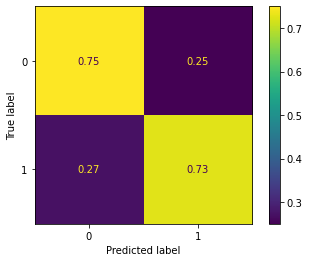

In [47]:
w = 0.62
class_weight = dict({0:1-w, 1: w})
# class_weight = 'balanced'
modelo = LogisticRegression(random_state=SEED, penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=class_weight, solver='liblinear', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
modelo = modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
modelo.score(X_test, y_test)


# replace Train by Test later
y_score = modelo.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print(f'Average precision-recall score: {average_precision:0.2f}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(modelo, X_test, y_test, normalize='true')  

In [48]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

In [49]:
feature_weights = (modelo.coef_**2).reshape(-1,1)
print(feature_weights.shape)
feature_weights = scaler.fit_transform(feature_weights).squeeze()
feature_weights = feature_weights[feature_weights>=0.1]

(219, 1)


In [50]:
feature_idx_descending = np.argsort(-feature_weights)
list(enumerate(zip(feature_weights[feature_idx_descending],df_train.columns.droplevel([1,2])[feature_idx_descending])))

[(0, (1.0, 'BLAST_MEAN')),
 (1, (0.6546393375836491, 'BIC_ARTERIAL_MIN')),
 (2, (0.6546393375836491, 'BIC_ARTERIAL_MEAN')),
 (3, (0.6546393375836491, 'BIC_ARTERIAL_MEDIAN')),
 (4, (0.6546393375836491, 'BE_VENOUS_DIFF')),
 (5, (0.4734245716705988, 'BILLIRUBIN_MEAN')),
 (6, (0.38919413588968327, 'HTN')),
 (7, (0.37371929423676314, 'CREATININ_MAX')),
 (8, (0.37262100438745055, 'FFA_MEAN')),
 (9, (0.3529023589106627, 'CALCIUM_MAX')),
 (10, (0.32557248998037136, 'CALCIUM_DIFF')),
 (11, (0.2947919952589486, 'BLAST_MAX')),
 (12, (0.2614375435895351, 'CALCIUM_MEAN')),
 (13, (0.2515866327943036, 'CALCIUM_MEDIAN')),
 (14, (0.23596792636085118, 'CREATININ_DIFF')),
 (15, (0.23572565905460463, 'BILLIRUBIN_MIN')),
 (16, (0.23307066282537506, 'CREATININ_MEDIAN')),
 (17, (0.20957493177549308, 'BLAST_MEDIAN')),
 (18, (0.20596417991489693, 'BE_ARTERIAL_MEDIAN')),
 (19, (0.20596417991489693, 'ALBUMIN_DIFF')),
 (20, (0.20596417991489693, 'ALBUMIN_MAX')),
 (21, (0.20596417991489693, 'ALBUMIN_MIN')),
 (22, 

Text(0.5, 1.0, '2-class Precision-Recall curve: \n AP=0.62')

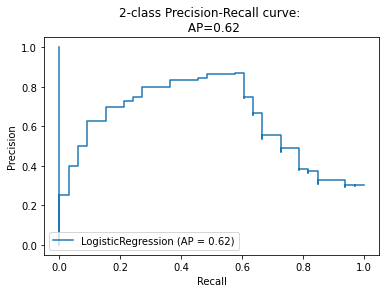

In [51]:
disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title(f'2-class Precision-Recall curve: \n AP={average_precision:0.2f}')

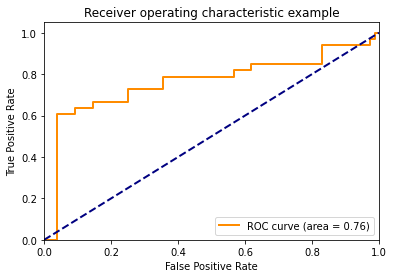

In [52]:
# Compute ROC curve and ROC area for each class
n_classes=2

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
w = .65
class_weight = dict({0:1-w, 1: w})
# class_weight = 'balanced'

modelo = DecisionTreeClassifier(random_state=SEED, class_weight=class_weight,
                                criterion='entropy', splitter='best', 
                                max_depth=4, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                                max_features=None, min_impurity_decrease=0.0, min_impurity_split=None,  ccp_alpha=0.0)

              precision    recall  f1-score   support

           0       0.80      0.70      0.75        76
           1       0.47      0.61      0.53        33

    accuracy                           0.67       109
   macro avg       0.63      0.65      0.64       109
weighted avg       0.70      0.67      0.68       109

[[53 23]
 [13 20]]


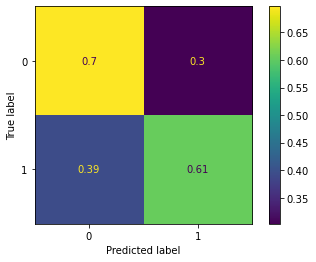

In [55]:
modelo = modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
modelo.score(X_test, y_test)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(modelo, X_test, y_test, normalize='true')  

Text(0.5, 1.0, '2-class Precision-Recall curve: \n AP=0.62')

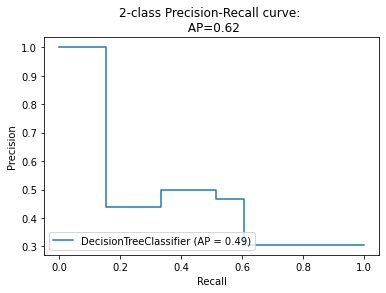

In [56]:
disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title(f'2-class Precision-Recall curve: \n AP={average_precision:0.2f}')

In [57]:
# revisar montagem do dataset multi-index (eliminar ICU do multi-índice de coluna? como guardar ICU? manter como coluna extra? combinar ICU com WINDOW?)
# feature-engineering nas variaveis continuas: eliminar menos influentes na reg. logística? acrescentar x**2 das que sobraram? x*y?
# usar dummies das variáveis categóricas